# Imports

In [6]:
import sympy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pickle
from scipy.optimize import root

from potencial import get_expressions

# %matplotlib widget

In [7]:
u_color = "#984ea3"
s_color = "#ff7f00"

In [8]:
X1, X2, I_L, I_C, I_R = sp.symbols('X1 X2 I_L I_C I_R')
tau = 0.1
values = {
    "tau": tau,
    "c": 1,
    "g": 1,
    "s0": 1,
    "IL": 1,
    "IC": 1,
    "IR": 1,
    "I_I": 1/3,
    "sL": 0,
    "sC": 0,
    "sR": 0,
}

potencial, F1, F2, _ = get_expressions(values, type = "symbolic", substituted_I = True)
_ ,_ ,_ , H = get_expressions(values, type = "symbolic", substituted_I = False)
potencial_num, F1_num, F2_num, H_num = get_expressions(values, type = "numeric", substituted_I = False)

# Function Definitions

## Find Saddles


In [9]:
def find_crit_pts(IL, IC, IR, seeds=None, tol=1e-8):
    """
    Resuelve g1=g2=0 con scipy.optimize.root devolviendo siempre
    un np.array de floats y usando method='lm'.
    """
    if seeds is None:
        seeds = [(i, j) for i in (-1, 0, 1) for j in (-1, 0, 1)]
    sols = set()
    
    def fun(vars):
        x, y = vars
        return np.array([
            F1_num(x, y, IL, IC, IR),
            F2_num(x, y, IL, IC, IR)
        ], dtype=float)
    
    for guess in seeds:
        sol = root(fun, guess, method='lm', tol=tol)
        if sol.success:
            x, y = sol.x
            sols.add((round(x,8), round(y,8)))
    return list(sols)


def compute_thresholds(IL, IC, IR):
    """
    Para una tripleta (IL, IC, IR), devuelve (th_r1, th_r2, th_r3),
    los mínimos umbrales positivos para r1=x+y, r2=-x+y, r3=-2y en los puntos silla.
    """
    cps = find_crit_pts(IL, IC, IR)
    
    saddle_pts = []
    for x, y in cps:
        evs = np.linalg.eigvals(H_num(x, y, IL, IC, IR))
        if evs[0] * evs[1] < 0:
            saddle_pts.append((x, y))
    
    r1s = [x + y    for x, y in saddle_pts if x + y    > 0]
    r2s = [-x + y   for x, y in saddle_pts if -x + y   > 0]
    r3s = [-2 * y   for x, y in saddle_pts if -2 * y   > 0]
    return (min(r1s) if r1s else None,
            min(r2s) if r2s else None,
            min(r3s) if r3s else None)

# === Ejemplo de uso ===
# IL_val, IC_val, IR_val son tus valores numéricos
IL_val, IC_val, IR_val = 1.0,1,1,
th1, th2, th3 = compute_thresholds(IL_val, IC_val, IR_val)
print(f"Thresholds: r1={th1:.4f}, r2={th2:.4f}, r3={th3:.4f}")

Thresholds: r1=1.1404, r2=1.1404, r3=1.0367


## Simulation Functions

In [10]:
def U_t(t, onset=0.5, offset=1.5, amplitude=2):
    return np.where(np.logical_or(t < onset, t > onset + offset), -1, -1 + amplitude * (t - onset) / offset)
def stim_t(t, onset=0.30, offset=1.7, amplitude=0.1):
    return np.where(np.logical_or(t < onset, t > onset + offset), 0, amplitude)

def drift(X, I_L=IL_val, I_C=IC_val, I_R=IR_val):
    x, y = X
    return np.array([F1_num(x, y, I_L, I_C, I_R), F2_num(x, y, I_L, I_C, I_R)])

def simulate_path(x0, S_amp = 0.1, S_onset = 0.3, S_offset = 1.7, U_amp = 2, U_onset =0.5, U_offset = 1.5, Tmax = 2, dt = tau/40, noise_amp = 1):
    N = int(Tmax / dt)
    X = np.empty((N+1, 2))
    X[0] = x0
    for i in range(N):
        x, y = X[i]
        dW = np.random.randn(3) * np.sqrt(dt)

        dB1 = (dW[0] - dW[1]) / 2
        dB2 = (dW[0] + dW[1] - 2*dW[2]) / 6
        U = U_t(i*dt, onset = U_onset,amplitude = U_amp, offset = U_offset)
        S = stim_t(i*dt, amplitude = S_amp, onset= S_onset, offset = S_offset)
        
        # Euler–Maruyama
        X[i+1] = X[i] + drift(X[i], U+S, U, U) * dt + noise_amp * np.array([dB1, dB2])

        r1 = (X[i+1, 0] + X[i+1, 1])  # r₁
        r2 = -X[i+1, 0] + X[i+1, 1] # r₂
        r3 = -2*X[i+1, 1]  # r₃
    th1,th2,th3 = 0.5, 0.5, 0.5
    # th1, th2, th3 = compute_thresholds(U+S, U, U)
    # if th1 is None:
    #     th1 = 0
    # if th2 is None:
    #     th2 = 0
    # if th3 is None:
    #     th3 = 0
    if   (r1>r2 and r1>r3 and r1>th1):
        winner = 'r1'
    elif (r2>r1 and r2>r3 and r2>th2):
        winner = 'r2'
    elif (r3>r1 and r3>r2 and r3>th3):
        winner = 'r3'
    else:
        winner = 'none'

    return X, winner                 


P(r₁ gana) = 0.638
P(r₂ gana) = 0.185
P(r₃ gana) = 0.177
P(no hay ganador) = 0.000


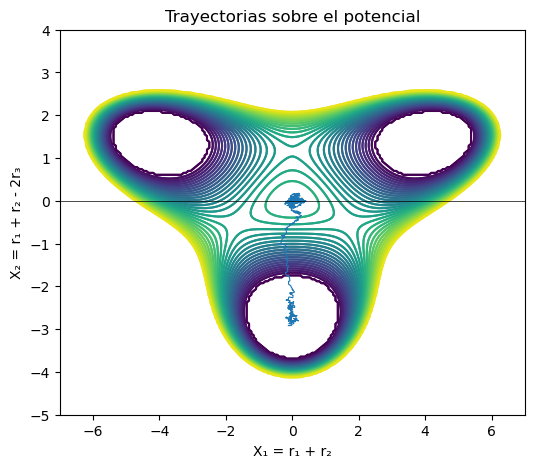

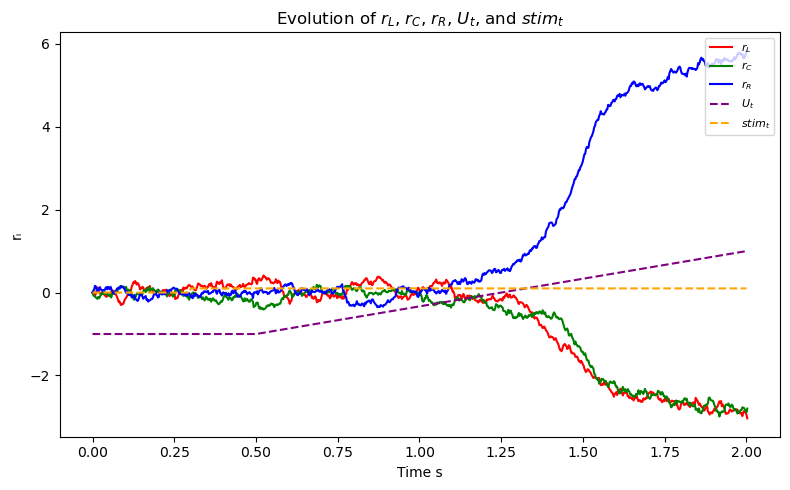

In [11]:
def drift(X, I_L=IL_val, I_C=IC_val, I_R=IR_val):
    x, y = X
    return np.array([F1_num(x, y, I_L, I_C, I_R), F2_num(x, y, I_L, I_C, I_R)/3])


V_num = potencial_num

theta     = 0.5         # umbral sobre r_i
noise_amp = 0.5        # intensidad del ruido
dt        = 1e-3        # paso de tiempo
dt = tau / 40
Tmax      = 2       # tiempo máximo de simulación
n_trajs   = 1000       # número de trayectorias Monte Carlo
x0        = np.array([0,0])  # condición inicial de ejemplo
r0 = np.array([0,0,0])  # posición inicial de la partícula
x0 = np.array([(r0[0]+r0[1])/2, (r0[0]-r0[1])/2])  # condición inicial en el espacio de fase


wins = {'r1': 0, 'r2': 0, 'r3': 0, 'none': 0}
all_paths = []

for _ in range(n_trajs):
    traj, win_type = simulate_path(x0, noise_amp=1)
    all_paths.append(traj)
    if win_type == 'r3':
        wins['r3'] += 1
    elif win_type == 'r1':
        wins['r1'] += 1
    elif win_type == 'r2':
        wins['r2'] += 1
    else:
        wins['none'] += 1


p_r1 = wins['r1'] / n_trajs
p_r2 = wins['r2'] / n_trajs
p_r3 = wins['r3'] / n_trajs
p_none = wins['none'] / n_trajs

print(f"P(r₁ gana) = {p_r1:.3f}")
print(f"P(r₂ gana) = {p_r2:.3f}")
print(f"P(r₃ gana) = {p_r3:.3f}")
print(f"P(no hay ganador) = {p_none:.3f}")

xs = np.linspace(-7, 7, 200)
ys = np.linspace(-5, 4, 200)
Xg, Yg = np.meshgrid(xs, ys)
Vg = V_num(Xg, Yg, 1,1,1)
Vg = np.clip(Vg, -100, 50)

plt.figure(figsize=(6, 5))

plt.contour(Xg, Yg, Vg, levels=30)
r1_vals = Xg + Yg
r2_vals = -Xg + Yg
r3_vals = -2 * Yg

plt.contour(Xg, Yg, Vg, levels=30)

# for U_s in saddle_us:
#     plt.contour(
#         Xg, Yg, Vg,
#         levels=[U_s],
#         colors='red',
#         linestyles='--',
#         linewidths=1.2
#     )

for traj in all_paths[:1]:
    plt.plot(traj[:,0], traj[:,1], lw=0.8)
plt.axhline(0, color='k', lw=0.5)
plt.xlabel('X₁ = r₁ + r₂')
plt.ylabel('X₂ = r₁ + r₂ - 2r₃')
plt.title('Trayectorias sobre el potencial')
plt.show()

def extract_r123(traj):
    X1_vals, X2_vals = traj[:, 0], traj[:, 1]
    r1_vals = (X1_vals + X2_vals)
    r2_vals = (-X1_vals + X2_vals)
    r3_vals = (-2 * X2_vals)
    return r1_vals, r2_vals, r3_vals
plt.figure(figsize=(8, 5))

for traj in all_paths[:1]:
    r1, r2, r3 = extract_r123(traj)
    t = np.linspace(0, len(traj) * dt, len(traj))
    plt.plot(t, r1, color='red', alpha=1, label=f'$r_L$')
    plt.plot(t, r2, color='green', alpha=1, label='$r_C$')
    plt.plot(t, r3, color='blue', alpha=1, label='$r_R$')

t_vals = np.linspace(0, Tmax, len(traj))
u_vals = U_t(t_vals)
stim_vals = stim_t(t_vals)
plt.plot(t_vals, u_vals, color='purple', linestyle='--', label='$U_t$')
plt.plot(t_vals, stim_vals, color='orange', linestyle='--', label='$stim_t$')


# positive_thresholds = [r for r in saddle_r1s if r > 0]
# if positive_thresholds:
#     lowest_th = min(positive_thresholds)
#     plt.axhline(
#         lowest_th,
#         color='k',
#         linestyle='-.',
#         linewidth=1,
#         label=f'Rate to reach the basins of attraction: {lowest_th:.3f}'
#     )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)

plt.xlabel("Time s")
plt.ylabel("rᵢ")
plt.title("Evolution of $r_L$, $r_C$, $r_R$, $U_t$, and $stim_t$")
plt.tight_layout()
plt.show()

Simulating trajectories: 100%|██████████| 1000/1000 [00:11<00:00, 85.56it/s]


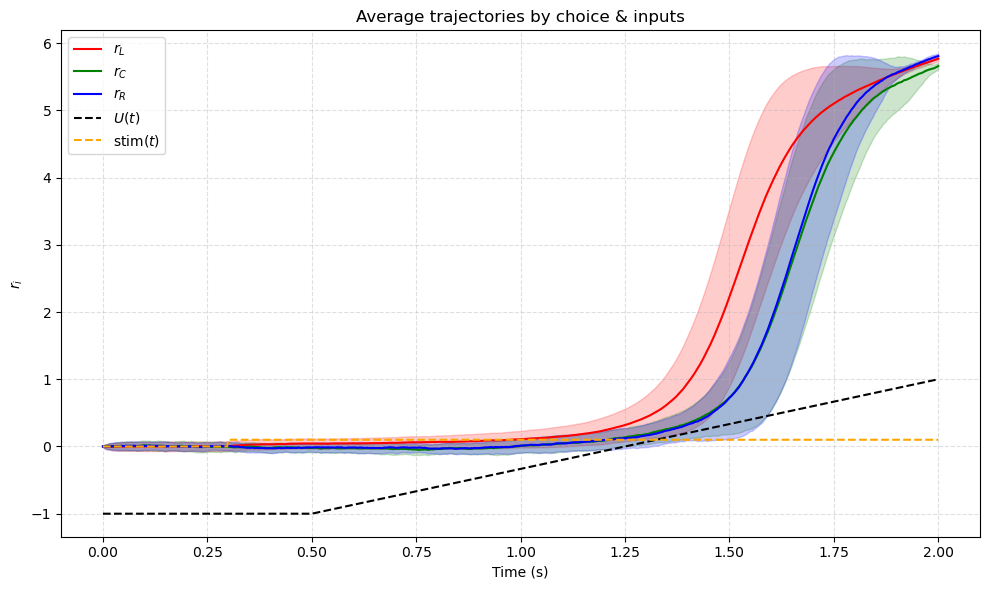

In [12]:
# 1) Simular y agrupar trials
r1_trials = []
r2_trials = []
r3_trials = []
n_trajs = 1000

for _ in tqdm(range(n_trajs), desc="Simulating trajectories"):
    traj, win_type = simulate_path(x0, noise_amp=0.5)
    r1, r2, r3 = extract_r123(traj)
    if win_type == 'r1':
        r1_trials.append(r1)
    elif win_type == 'r2':
        r2_trials.append(r2)
    elif win_type == 'r3':
        r3_trials.append(r3)
    # los trials sin umbral los ignoramos

min_len = min(len(r) for groupe in (r1_trials, r2_trials, r3_trials) for r in groupe)
t = np.linspace(0, dt*(min_len-1), min_len)

def plot_avg(trials, label, color):
    arr = np.array([r[:min_len] for r in trials])
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0)
    plt.plot(t, mean, label=label, color=color, lw=1.5)
    plt.fill_between(t, mean-std, mean+std, color=color, alpha=0.2)

plt.figure(figsize=(10, 6))
if r1_trials:
    plot_avg(r1_trials, '$r_L$', 'red')
if r2_trials:
    plot_avg(r2_trials, '$r_C$', 'green')
if r3_trials:
    plot_avg(r3_trials, '$r_R$', 'blue')

U_vals   = U_t(t)
stim_vals= stim_t(t)
plt.plot(t, U_vals,    'k--', label='$U(t)$',   lw=1.5)
plt.plot(t, stim_vals, 'orange', linestyle='--', label='$\\mathrm{stim}(t)$', lw=1.5)

plt.xlabel('Time (s)')
plt.ylabel('$r_i$')
plt.title('Average trajectories by choice & inputs')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


Simulando trayectorias: 100%|██████████| 1000/1000 [00:11<00:00, 85.53it/s]
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_2674/3920190075.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot(t_full, U_t(t_full),    'k--',    label='$U(t)$', color = u_color,   lw=1.5)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_2674/3920190075.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "orange" (-> color=(1.0, 0.6470588235294118, 0.0, 1.0)). The keyword argument will take precedence.
  ax2.plot(t_full, stim_t(t_full), 'orange', linestyle='--', color = s_color, label='$\\mathrm{stim}(t)$', lw=1.5)


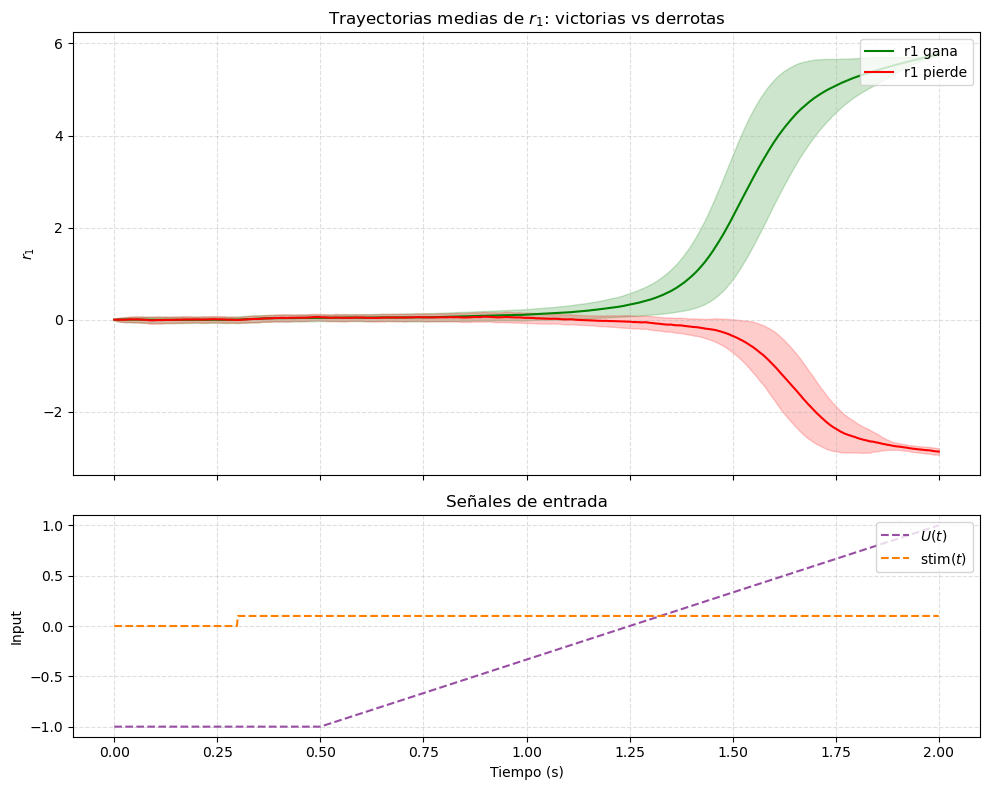

In [91]:
n_trajs = 1000
r1_win_trials = []
r1_loss_trials = []

for _ in tqdm(range(n_trajs), desc="Simulando trayectorias"):
    traj, win_type = simulate_path(x0, noise_amp=0.5)
    r1, _, _ = extract_r123(traj)
    if win_type == 'r1':
        r1_win_trials.append(r1)
    elif win_type in ('r2', 'r3'):
        r1_loss_trials.append(r1)

# Calcula media y std sin recortar al mismo largo
def compute_mean_std(trials):
    max_len = max(len(r) for r in trials)
    mean = np.zeros(max_len)
    std  = np.zeros(max_len)
    for i in range(max_len):
        vals = [r[i] for r in trials if len(r) > i]
        mean[i] = np.mean(vals)
        std[i]  = np.std(vals)
    t = np.arange(max_len) * dt
    return t, mean, std

t_win,  mean_win,  std_win  = compute_mean_std(r1_win_trials)
t_loss, mean_loss, std_loss = compute_mean_std(r1_loss_trials)

# Prepara subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

# --- Primer plot: r1 wins vs losses ---
ax1.plot(t_win, mean_win,      label='r1 gana',  color='green', lw=1.5)
ax1.fill_between(t_win,
                 mean_win-std_win,
                 mean_win+std_win,
                 color='green', alpha=0.2)

ax1.plot(t_loss, mean_loss,      label='r1 pierde',  color='red', lw=1.5)
ax1.fill_between(t_loss,
                 mean_loss-std_loss,
                 mean_loss+std_loss,
                 color='red', alpha=0.2)

ax1.set_ylabel('$r_1$')
ax1.set_title('Trayectorias medias de $r_1$: victorias vs derrotas')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(loc='upper right')

t_max = max(t_win.max(), t_loss.max())
t_full = np.linspace(0, t_max, int(t_max/dt) + 1)

ax2.plot(t_full, U_t(t_full),    'k--',    label='$U(t)$', color = u_color,   lw=1.5)
ax2.plot(t_full, stim_t(t_full), 'orange', linestyle='--', color = s_color, label='$\\mathrm{stim}(t)$', lw=1.5)

ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Input')
ax2.set_title('Señales de entrada')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


Simulando: 100%|██████████| 10000/10000 [01:59<00:00, 83.47it/s]


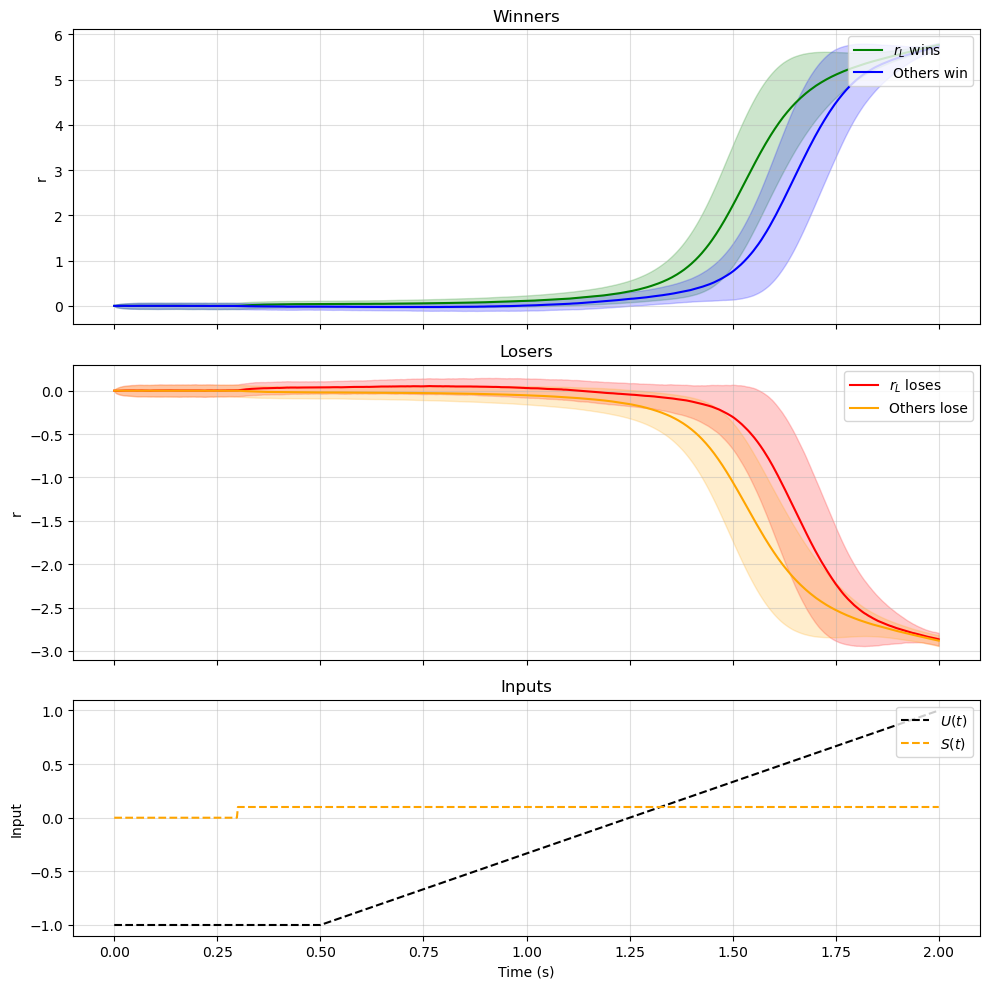

In [104]:
r1_win, r1_loss, other_win, other_loss = [], [], [], []
n_trajs = 10000

for _ in tqdm(range(n_trajs), desc="Simulando"):
    traj, win = simulate_path(x0, noise_amp=0.5)
    r1, r2, r3 = extract_r123(traj)
    if win == 'r1':
        r1_win.append(r1)
        other_loss += [r2, r3]
    elif win == 'r2':
        other_win.append(r2)
        r1_loss.append(r1)
        other_loss.append(r3)
    else:  # win == 'r3'
        other_win.append(r3)
        r1_loss.append(r1)
        other_loss.append(r2)


def avg_std(trials):
    if not trials:
        return np.array([]), np.array([]), np.array([])
    L = max(len(r) for r in trials)
    arr = np.array([np.pad(r, (0, L - len(r)), constant_values=np.nan)
                    for r in trials], dtype=float)
    mean = np.nanmean(arr, axis=0)
    std  = np.nanstd(arr, axis=0)
    t    = np.arange(L) * dt
    return t, mean, std


t_w1, m_w1, s_w1 = avg_std(r1_win)
t_wo, m_wo, s_wo = avg_std(other_win)
t_l1, m_l1, s_l1 = avg_std(r1_loss)
t_lo, m_lo, s_lo = avg_std(other_loss)


fig, (ax1, ax2, ax3) = plt.subplots(3,1,
                                    figsize=(10,10),
                                    sharex=True,
                                    gridspec_kw={'height_ratios': [1,1,0.8]})


if t_w1.size:
    ax1.plot(t_w1, m_w1, color='green', label='$r_L$ wins', lw=1.5)
    ax1.fill_between(t_w1, m_w1-s_w1, m_w1+s_w1, color='green', alpha=0.2)
if t_wo.size:
    ax1.plot(t_wo, m_wo, color='blue',  label='Others win', lw=1.5)
    ax1.fill_between(t_wo, m_wo-s_wo, m_wo+s_wo, color='blue', alpha=0.2)
ax1.set(title='Winners', ylabel='r')
ax1.grid('--', alpha=0.4)
ax1.legend(loc='upper right')


if t_l1.size:
    ax2.plot(t_l1, m_l1, color='red',    label='$r_L$ loses', lw=1.5)
    ax2.fill_between(t_l1, m_l1-s_l1, m_l1+s_l1, color='red', alpha=0.2)
if t_lo.size:
    ax2.plot(t_lo, m_lo, color='orange', label='Others lose', lw=1.5)
    ax2.fill_between(t_lo, m_lo-s_lo, m_lo+s_lo, color='orange', alpha=0.2)
ax2.set(title='Losers', ylabel='r')
ax2.grid('--', alpha=0.4)
ax2.legend(loc='upper right')

# — Subplot 3: Entradas U(t) y stim(t) —
# Calculamos un t_full que cubra el rango máximo
t_max = max(t_w1.max() if t_w1.size else 0,
            t_l1.max() if t_l1.size else 0)
t_full = np.linspace(0, t_max, int(t_max/dt) + 1)

ax3.plot(t_full, U_t(t_full),    linestyle='--', color=u_color, label='$U(t)$',    lw=1.5)
ax3.plot(t_full, stim_t(t_full), linestyle='--', color=s_color, label='$S(t)$', lw=1.5)
ax3.set(title='Inputs', xlabel='Time (s)', ylabel='Input')
ax3.grid('--', alpha=0.4)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
def plot_rates(traj, onset, offset, U_amp, U_onset, Tmax = 3, dt = tau/40):
    t = np.linspace(0, len(traj) * dt, len(traj))
    t_vals = np.linspace(0, Tmax, len(traj))
    u_vals = U_t(t_vals, amplitude=U_amp, onset=U_onset)
    stim_vals = stim_t(t_vals, onset=onset, offset=offset)

    r1, r2, r3 = extract_r123(traj)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax1.plot(t, r1, color='red',   label=r'$r_L$')
    ax1.plot(t, r2, color='green', label=r'$r_C$')
    ax1.plot(t, r3, color='blue',  label=r'$r_R$')
    ax1.axhline(0.5, color='k', linestyle='-.',
                linewidth=1, label='Umbral: 0.5')
    # ax1.set_ylim(-2, 3)
    ax1.set_ylabel('Rates $r_i$')
    ax1.set_title('Evolution of $r_L$, $r_C$, $r_R$')
    ax1.legend(loc='upper right')

    ax2.plot(t_vals, u_vals,   linestyle='-', label=r'$U(t)$', color = u_color, alpha=1)
    ax2.plot(t_vals, stim_vals,linestyle='-', label=r'$S(t)$',color = s_color, alpha=1)
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Amplitud')
    ax2.set_title('Inputs $U(t)$ and $S(t)$')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
ff


# Stimulus and Urgency signal fitting

## General adjustments

In [109]:
dt      = tau / 40
Tmax    = 2.0
n_trajs = 500
x0      = np.array([0., 0.])
noise_amp = 1

onset_fix= 0.3
offset_fix= 0.3
U_amp_fix = 2
U_onset = 0.5

### S Onset

Simulating for different onsets: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]


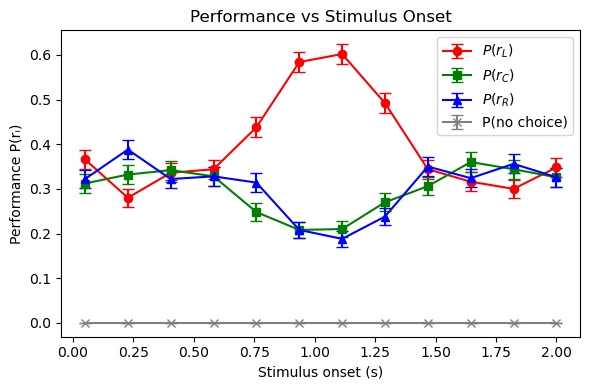

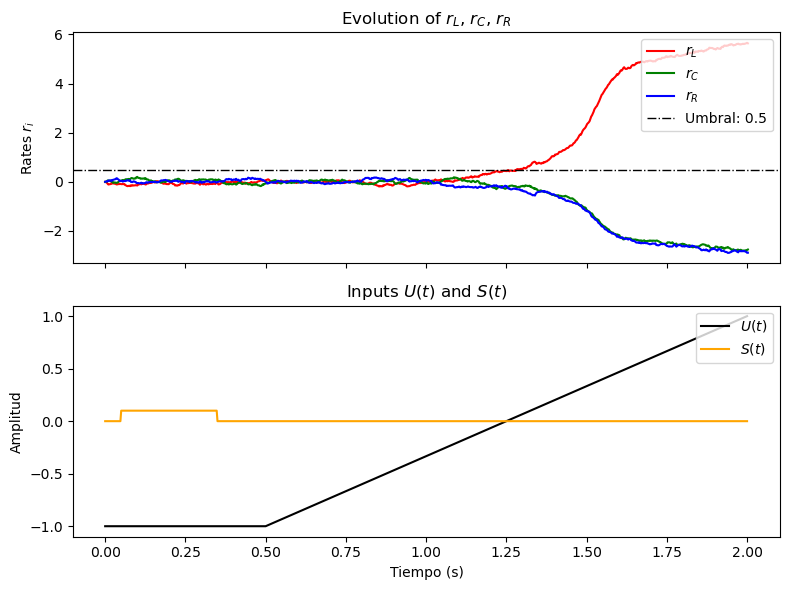

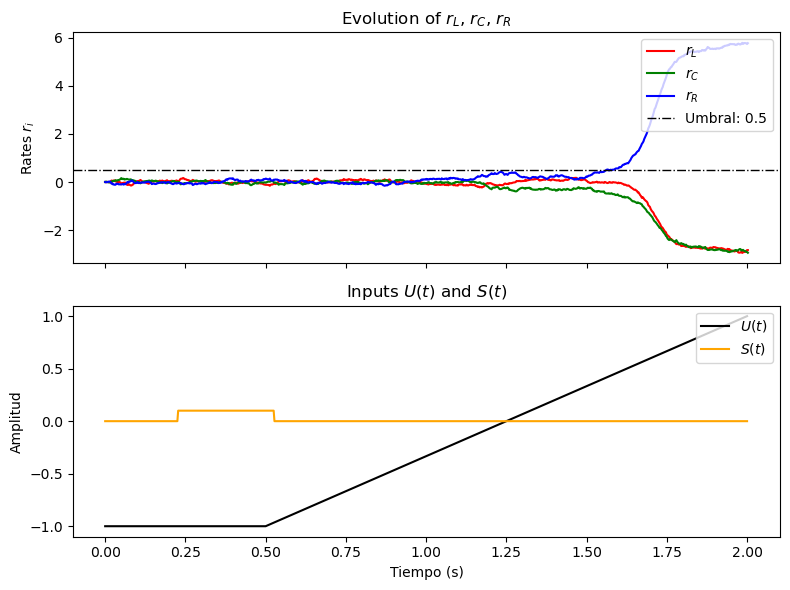

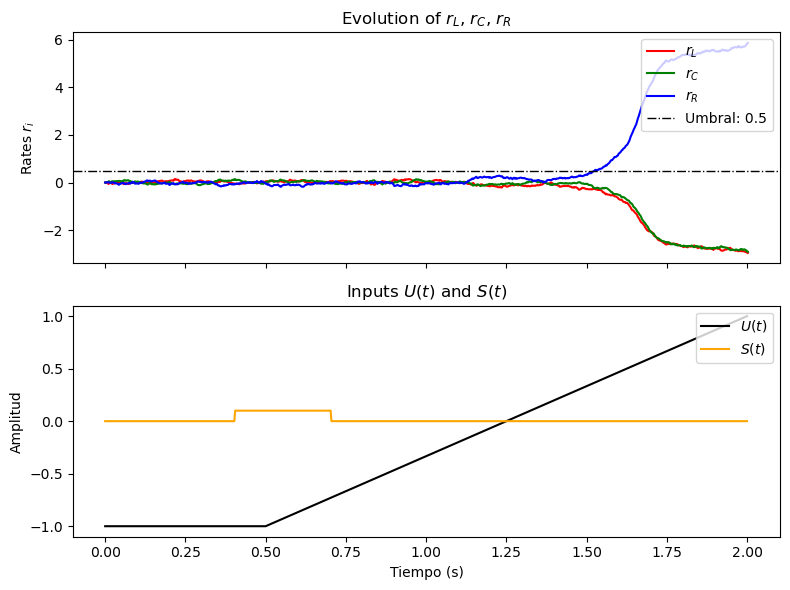

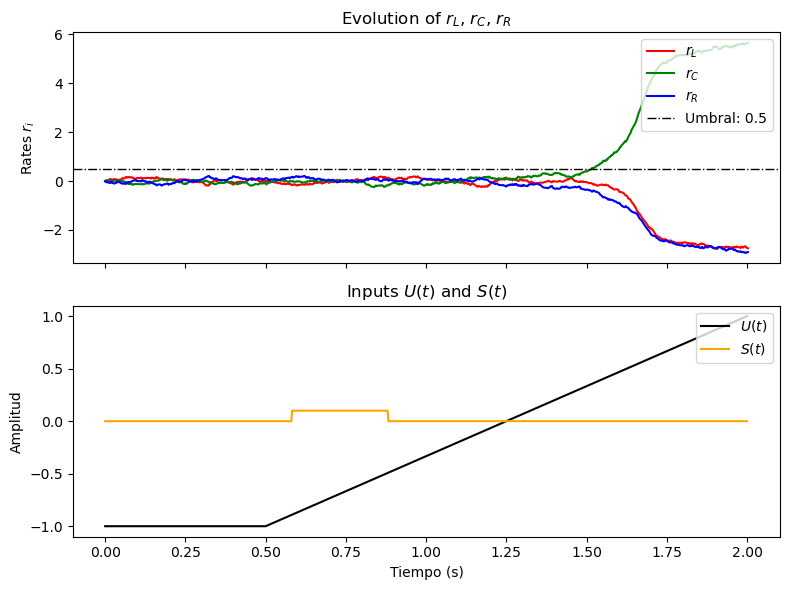

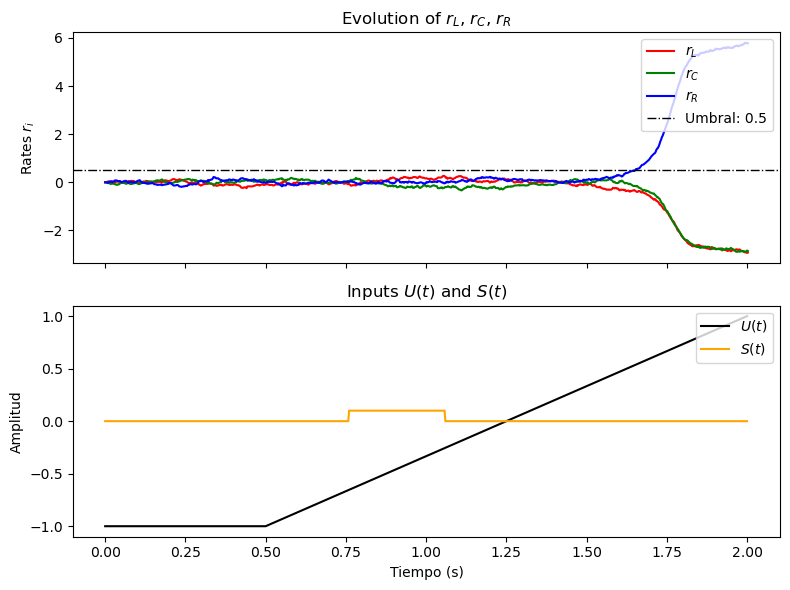

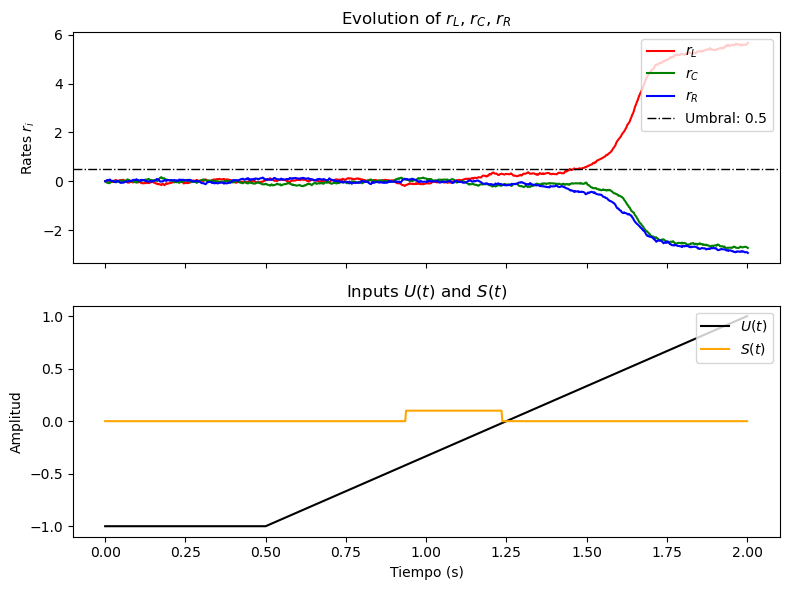

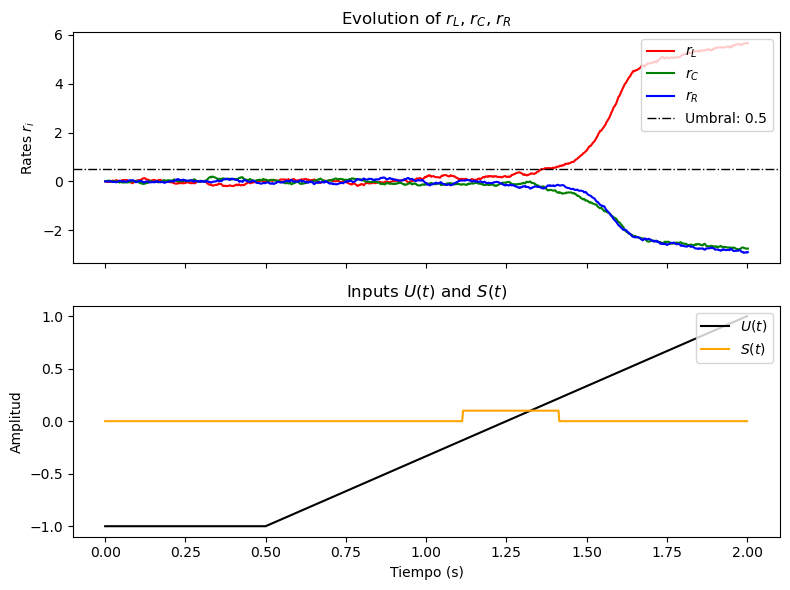

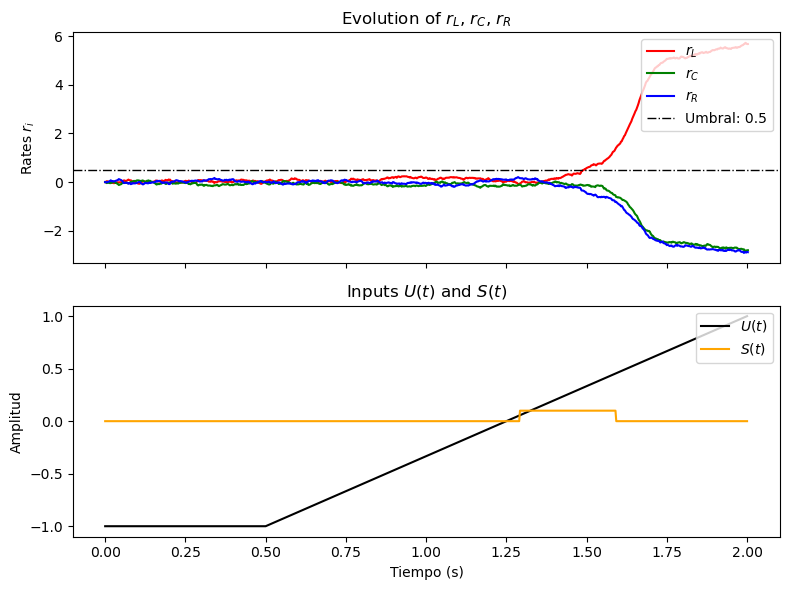

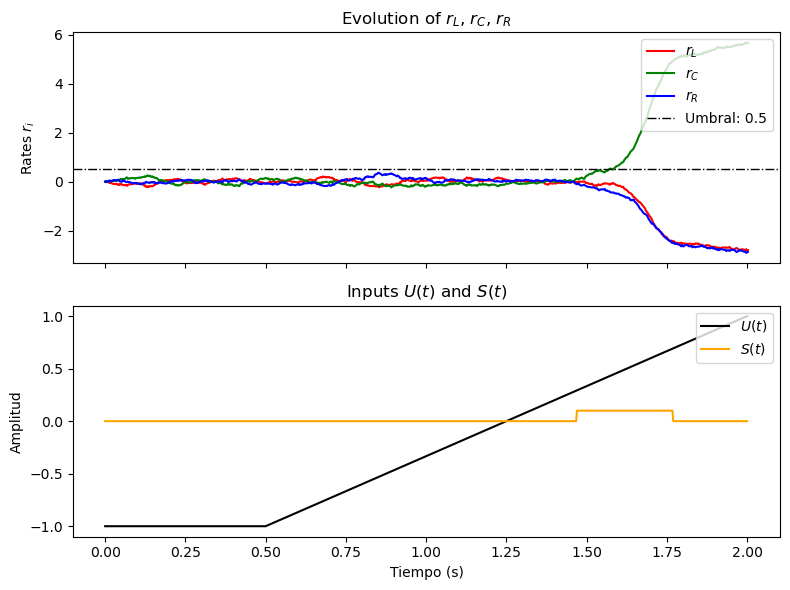

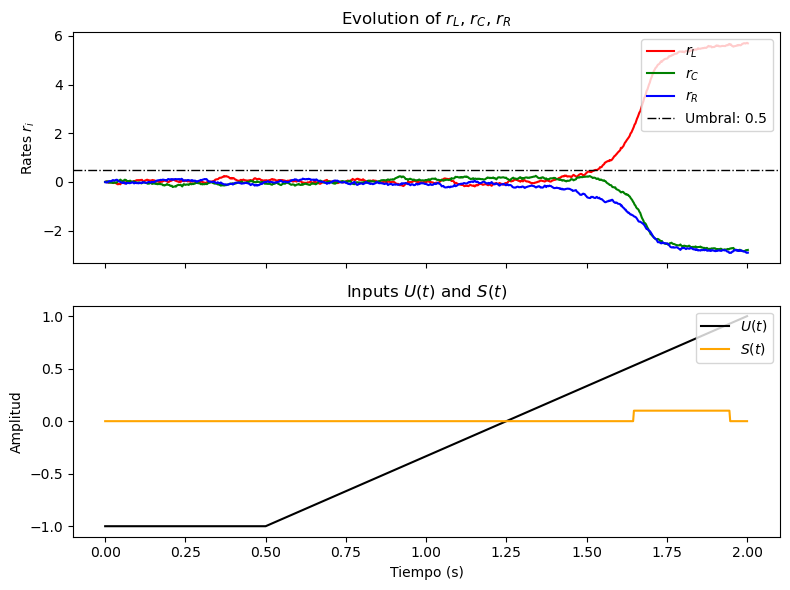

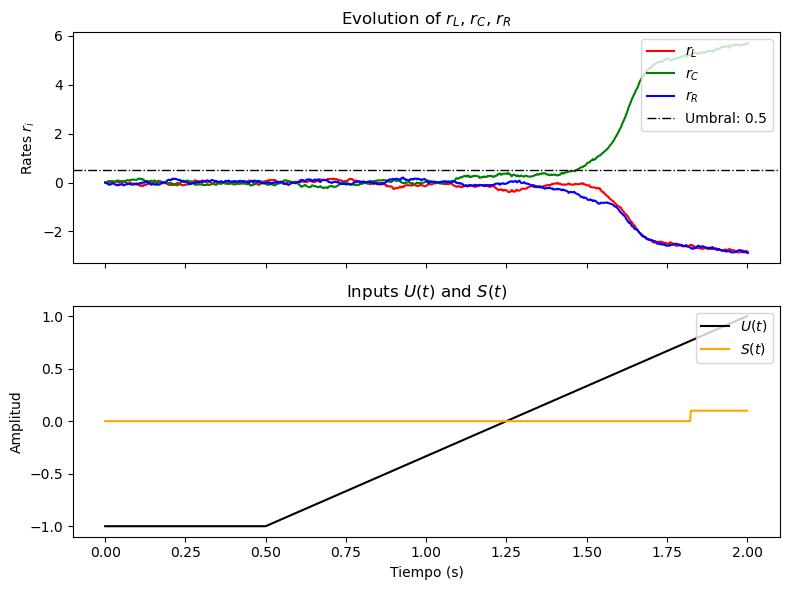

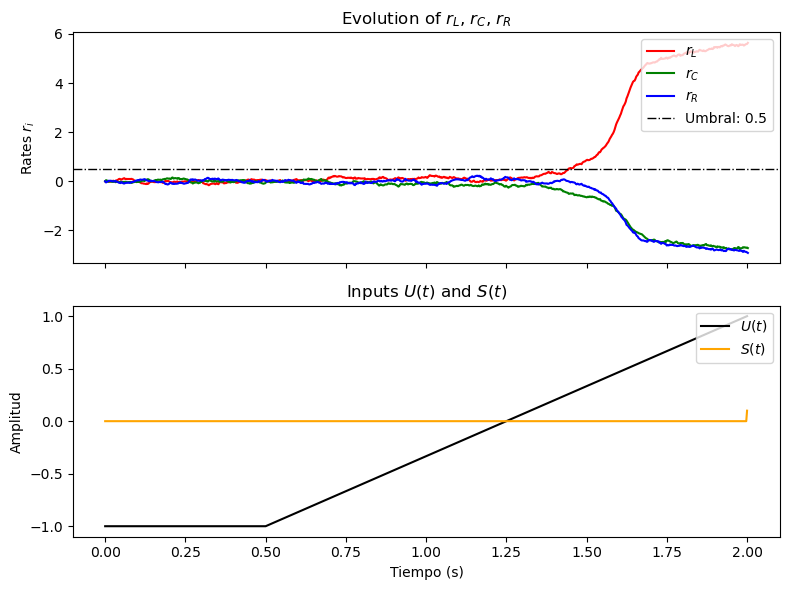

In [110]:
onsets    = np.linspace(0.05, 2.0, 12)

p_onset = np.zeros((4, len(onsets)))
X_first = [] 
for i, onset in enumerate(tqdm(onsets, desc="Simulating for different onsets")):
    wins = {'r1': 0, 'r2': 0, 'r3': 0, 'none': 0}
    for k in range(n_trajs):
        X, w = simulate_path(x0, S_onset=onset, S_offset=offset_fix, U_amp=U_amp_fix, U_onset=U_onset, noise_amp=0.5, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p_onset[:, i] = [wins['r1'] / total, wins['r2'] / total, wins['r3'] / total, wins['none'] / total]

p_onset_err = np.sqrt(p_onset * (1 - p_onset) / n_trajs)

plt.figure(figsize=(6,4))
plt.errorbar(onsets, p_onset[0], yerr=p_onset_err[0],
             fmt='-o', label=r'$P(r_L)$', color='red',   capsize=4)
plt.errorbar(onsets, p_onset[1], yerr=p_onset_err[1],
             fmt='-s', label=r'$P(r_C)$', color='green', capsize=4)
plt.errorbar(onsets, p_onset[2], yerr=p_onset_err[2],
             fmt='-^', label=r'$P(r_R)$', color='blue',  capsize=4)
plt.errorbar(onsets, p_onset[3], yerr=p_onset_err[3],
             fmt='-x', label='P(no choice)', color='gray', capsize=4)
plt.xlabel('Stimulus onset (s)')
plt.ylabel('Performance P(rᵢ)')
plt.title('Performance vs Stimulus Onset')
plt.legend()
plt.tight_layout()

for X, on in zip(X_first, onsets):
    plot_rates(X, on, offset_fix, U_amp_fix, U_onset, Tmax=2, dt=dt)


### S Offset

Simulating for different offsets: 100%|██████████| 10/10 [01:44<00:00, 10.40s/it]


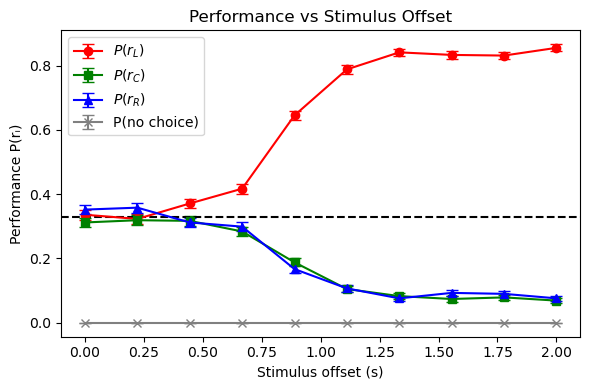

In [37]:
offsets   = np.linspace(0, 2.0, 10)

p_offset = np.zeros((4, len(offsets)))
X_first = [] 
for j, offset in enumerate(tqdm(offsets, desc="Simulating for different offsets")):
    wins = {'r1':0,'r2':0,'r3':0, 'none': 0}
    for _ in range(n_trajs):
        X ,w = simulate_path(x0, S_onset=onset_fix, S_offset=offset, U_amp=U_amp_fix, U_onset=U_onset, noise_amp=0.5, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p_offset[:,j] = [wins['r1']/total, wins['r2']/total, wins['r3']/total, wins['none']/total]

p_offset_err = np.sqrt(p_offset * (1 - p_offset) / n_trajs)

plt.figure(figsize=(6,4))
plt.errorbar(offsets, p_offset[0], yerr=p_offset_err[0],
             fmt='-o', label=r'$P(r_L)$', color='red',   capsize=4)
plt.errorbar(offsets, p_offset[1], yerr=p_offset_err[1],
             fmt='-s', label=r'$P(r_C)$', color='green', capsize=4)
plt.errorbar(offsets, p_offset[2], yerr=p_offset_err[2],
             fmt='-^', label=r'$P(r_R)$', color='blue',  capsize=4)
plt.errorbar(offsets, p_offset[3], yerr=p_offset_err[3],
             fmt='-x', label='P(no choice)', color='gray', capsize=4)
plt.axhline(0.33, color='black', linestyle='--', label='')
plt.xlabel('Stimulus offset (s)')
plt.ylabel('Performance P(rᵢ)')
plt.title('Performance vs Stimulus Offset')
plt.legend()
plt.tight_layout()

for X, of in zip(X_first, offsets):
    plot_rates(X, onset_fix, of, U_amp_fix, U_onset, U_amp=U_amp_fix, Tmax=2, dt=dt)


### U Amplitude

Simulating for different U amplitudes: 100%|██████████| 10/10 [01:45<00:00, 10.54s/it]


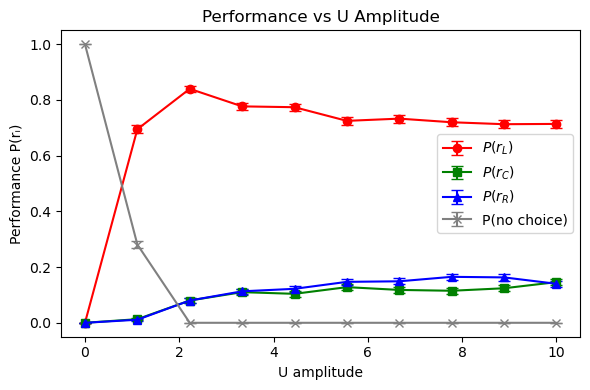

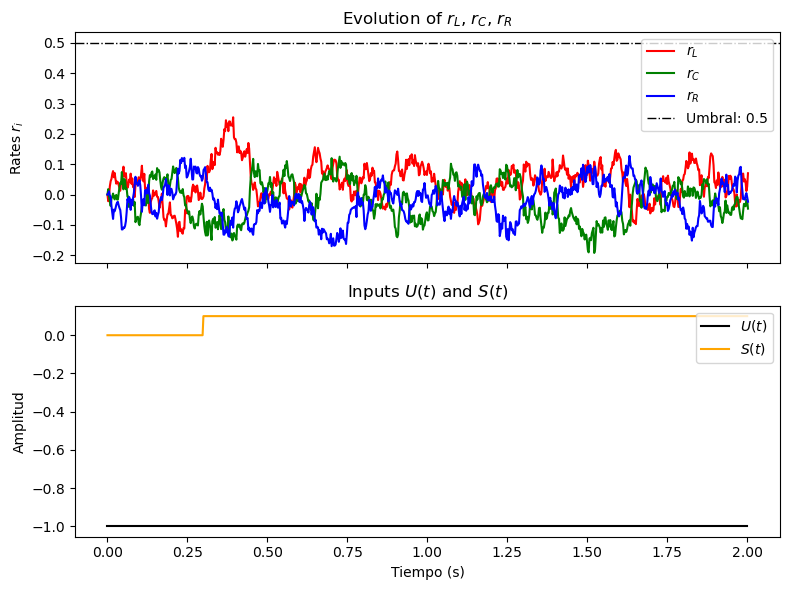

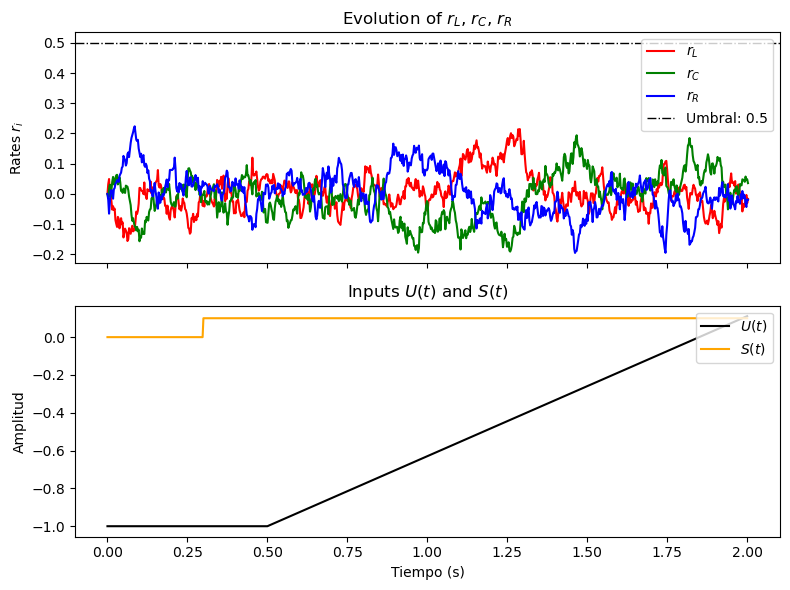

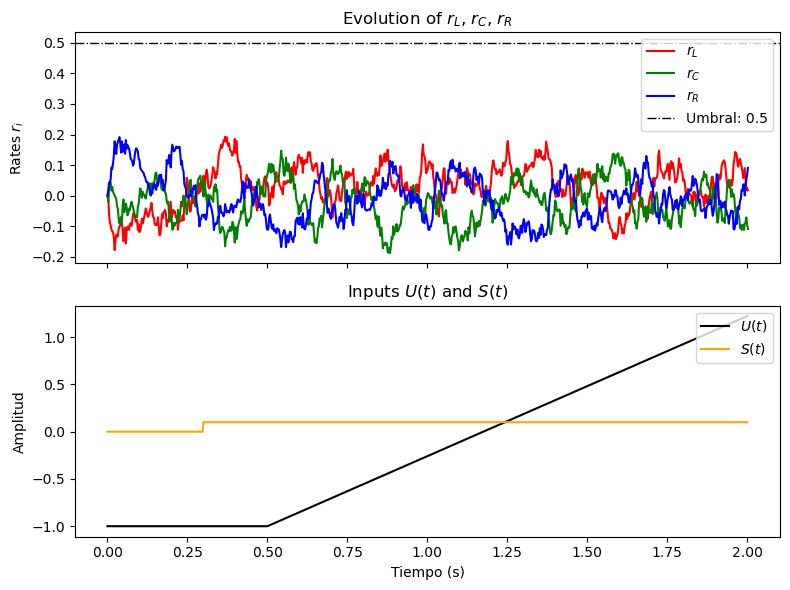

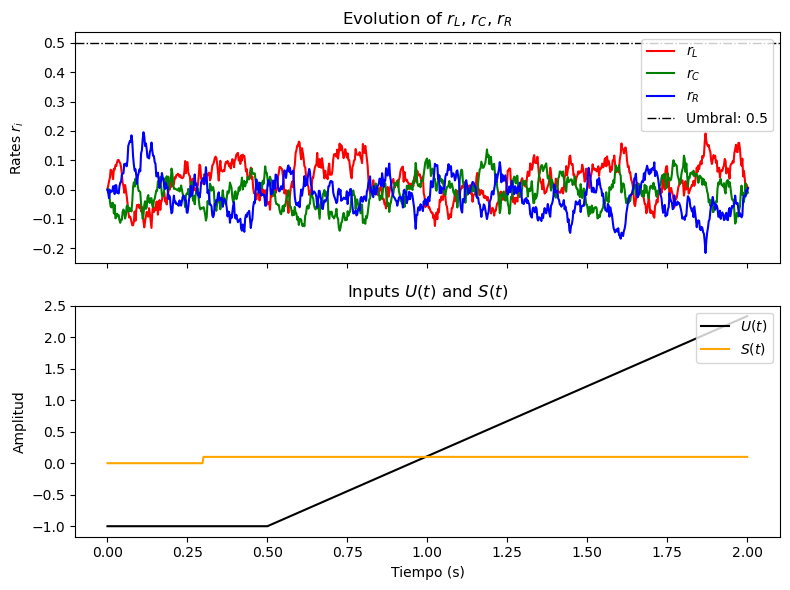

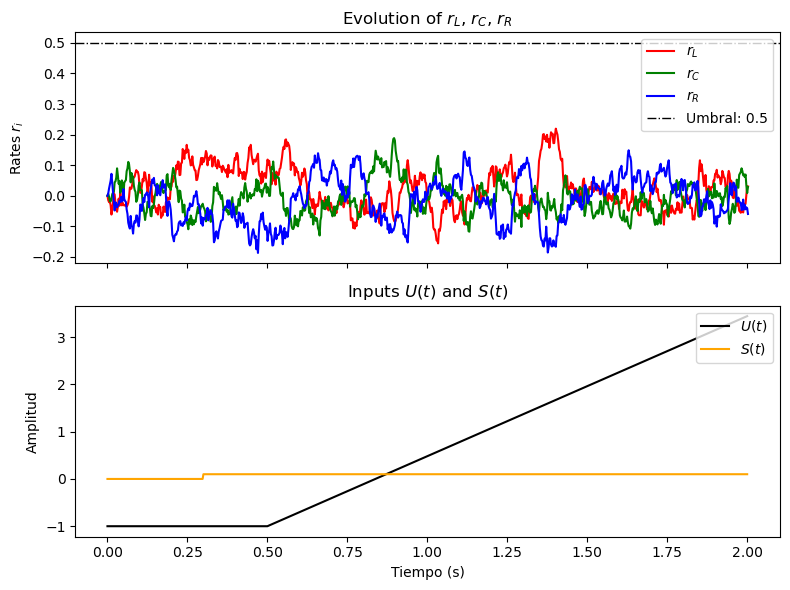

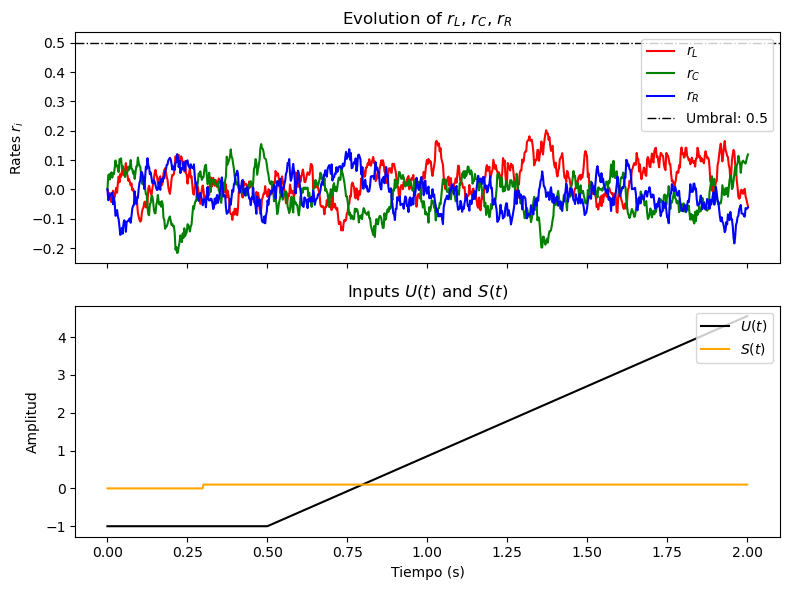

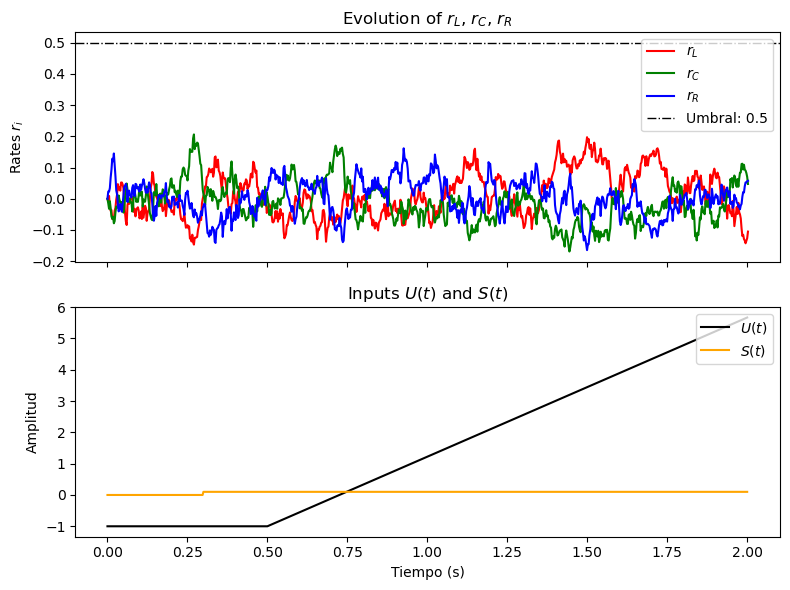

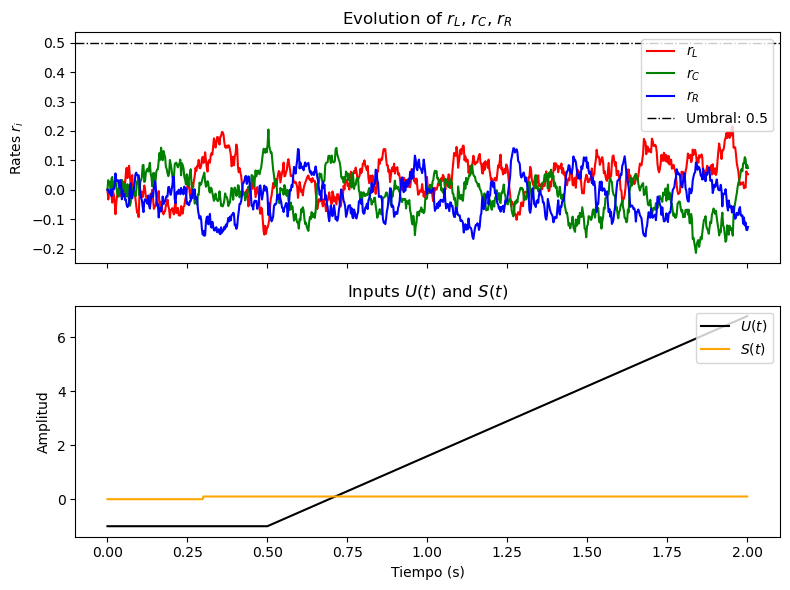

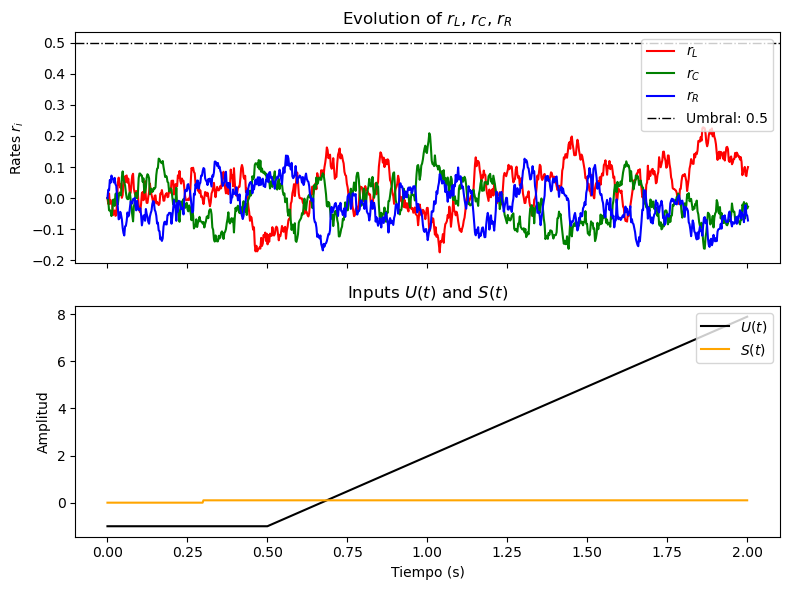

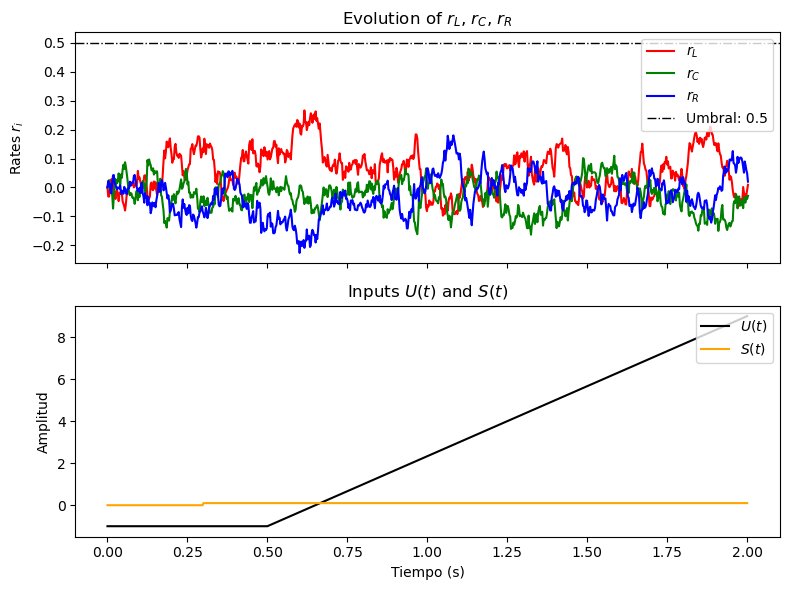

In [103]:
U_amps    = np.linspace(0, 10.0, 10)
stim_on   = 0.3
stim_off  = 1.7
stim_amp  = 0.1
U_onset = 0.5
n_trajs = 1000

p_Uamp = np.zeros((4, len(U_amps)))
X_first = [] 
for k, U_amp in enumerate(tqdm(U_amps, desc="Simulating for different U amplitudes")):
    wins = {'r1':0,'r2':0,'r3':0,'none': 0}
    for _ in range(n_trajs):
        X ,w = simulate_path(x0, S_onset=stim_on, S_offset=stim_off, U_amp=U_amp, U_onset=U_onset, noise_amp=0.5, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p_Uamp[:,k] = [wins['r1']/total, wins['r2']/total, wins['r3']/total, wins['none']/total]

p_err = np.sqrt(p_Uamp * (1 - p_Uamp) / n_trajs)

plt.figure(figsize=(6,4))
# plt.plot(U_amps,  p_Uamp[0], '-o', label=f'$P(r_L)$', color='red')
# plt.plot(U_amps,  p_Uamp[1], '-s', label=f'$P(r_C)$', color='green')
# plt.plot(U_amps,  p_Uamp[2], '-^', label=f'$P(r_R)$', color='blue')
# plt.plot(U_amps,  p_Uamp[3], '-x', label='P(no choice)', color='gray')
plt.errorbar(U_amps, p_Uamp[0], yerr=p_err[0],
             fmt='-o', label=r'$P(r_L)$', color='red',   capsize=4)
plt.errorbar(U_amps, p_Uamp[1], yerr=p_err[1],
             fmt='-s', label=r'$P(r_C)$', color='green', capsize=4)
plt.errorbar(U_amps, p_Uamp[2], yerr=p_err[2],
             fmt='-^', label=r'$P(r_R)$', color='blue',  capsize=4)
plt.errorbar(U_amps, p_Uamp[3], yerr=p_err[3],
             fmt='-x', label='P(no choice)', color='gray', capsize=4)
plt.xlabel('U amplitude')
plt.ylabel('Performance P(rᵢ)')
plt.title('Performance vs U Amplitude')
plt.legend()
plt.tight_layout()

plt.show()
for X, amp in zip(X_first, U_amps):
    plot_rates(X, onset = stim_on,offset= stim_off,U_amp= amp, U_onset = U_onset, Tmax=2, dt =dt)

In [ ]:
for X, amp in zip(X_first, U_amps):
    plot_rates(X, onset = stim_on,offset= stim_off,U_amp= amp, U_onset = U_onset, Tmax=2)

In [ ]:
def find_critical(ILv, ICv, IRv):
    x_guess = np.linspace(-10, 10, 5)
    y_guess = np.linspace(-10, 10, 5)
    initial_guesses = np.array(np.meshgrid(x_guess, y_guess)).T.reshape(-1, 2)
    def grad_wrap(pt):
        return np.array(grad_func(pt[0], pt[1], ILv, ICv, IRv), float)
    found = []
    for guess in initial_guesses:
        sol = fsolve(grad_wrap, guess)
        sol = np.round(sol, 4)
        if not any(np.allclose(sol, f) for f in found):
            found.append(sol)
    # clasificar tipo con Hessiana
    crit_pts = []
    for sol in found:
        H_num = np.array(H.subs({X1:sol[0], X2:sol[1], I_L:ILv, I_C:ICv, I_R:IRv}), float)
        eigs = np.linalg.eigvals(H_num)
        if np.all(eigs>0):   ptype='Minimum'
        elif np.all(eigs<0): ptype='Maximum'
        else:                ptype='Saddle'
        crit_pts.append((sol[0], sol[1], ptype))
    return crit_pts



# Videos

## 2D

In [ ]:
lam_potential = potencial_num
grad_func = lambda x, y, IL, IC, IR: [F1_num(x, y, IL, IC, IR), F2_num(x, y, IL, IC, IR)]


t_vals_ms = np.linspace(0, 2000, 200)
t_secs = t_vals_ms / 1000.0
x0 = [0.0, 0.0] 
winner = 'r1'
# while winner != 'none':
X_path, winner = simulate_path(
    x0,
    S_onset = 0.3,
    S_offset = 1.7,
    U_amp    = 3,
    U_onset  = 0.5,
    Tmax     = 2.0,   
    dt       = 0.01, 
    noise_amp= 0.5
)
print(f'Ganador: {winner}')

U_vals = U_t(t_secs, amplitude = 3, onset=0.5)
S_vals = stim_t(t_secs, onset=0.3, offset=1.7)


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10), constrained_layout=True)

x = np.linspace(-15, 15, 200)
y = np.linspace(-15, 15, 100)
Xg, Yg = np.meshgrid(x, y)



ax2.plot(t_vals_ms, U_vals, label='$U_t(t)$')
ax2.plot(t_vals_ms, S_vals, label='$S_t(t)$')
vline = ax2.axvline(t_vals_ms[0], color='red', lw=2)
ax2.set_xlabel('Tiempo (ms)');  ax2.set_ylabel('Amplitud')
ax2.legend(); 




def update(frame):
    t_ms = t_vals_ms[frame]
    Uv, Sv = U_vals[frame], S_vals[frame]
    ILv, ICv, IRv = Uv+Sv, Uv, Uv

    V = lam_potential(Xg, Yg, ILv, ICv, IRv)
    ax1.clear()
    cf = ax1.contourf(Xg, Yg, V, levels=30, cmap='viridis')
    V = np.clip(V, -50, 50)
    crit_pts = find_critical(ILv, ICv, IRv)
    for x0_, y0_, ptype in crit_pts:
        color = {'Minimum':'blue','Maximum':'red','Saddle':'green'}[ptype]
        ax1.scatter(x0_, y0_, c=color, s=80, edgecolors='k', zorder=3)
    # leyenda de tipos
    for label,color in [('Min','blue'),('Max','red'),('Saddle','green')]:
        ax1.scatter([], [], c=color, label=label, s=80, edgecolors='k')
    ax1.legend(title='Tipo')

    i = min(frame, X_path.shape[0]-1)
    ax1.plot(X_path[:i,0], X_path[:i,1], linewidth=2, color='white', alpha=0.8)
    ax1.scatter(X_path[i,0], X_path[i,1],
                s=50, c='yellow', edgecolors='k', zorder=4)

    ax1.set_title(f'Potencial en t = {t_ms:.1f} ms (ganador: {winner})')
    ax1.set_aspect('equal');  ax1.grid(alpha=0.3)

    vline.set_xdata([t_ms, t_ms])
    return cf.collections + [vline]


anim = FuncAnimation(fig, update, frames=len(t_vals_ms), interval=50, blit=False)
HTML(anim.to_html5_video())


## 3D

In [ ]:


# parameters = {
#     x0: [0, 0],
#     S_onset: 0.3,
#     S_offset: 1.7,
#     U_amp: 5,
#     U_onset: 0.5,
#     Tmax: 2.0,
#     dt: 0.01,
#     noise_amp: 1
# }

t_vals_ms = np.linspace(0, 2000, 200)
t_secs = t_vals_ms / 1000.0
X_path, winner = simulate_path(
    x0=[0,0], S_onset=0.3, S_offset=1.7, U_amp=3, U_onset=0.5,
    Tmax=2.0, dt=0.01, noise_amp=1
)
U_vals = U_t(t_secs, amplitude=3, onset=0.5)
S_vals = stim_t(t_secs, onset=0.3, offset=1.7)

# Creamos la malla 2D fija para X,Y
xg = np.linspace(-10, 7, 100)
yg = np.linspace(-5, 4, 100)
Xg, Yg = np.meshgrid(xg, yg)

# Figura con dos subplots: uno 3D y otro para estímulos
fig = plt.figure(figsize=(8,10), constrained_layout=True)
ax1 = fig.add_subplot(2,1,1, projection='3d')
ax2 = fig.add_subplot(2,1,2)

# Panel de estímulos
ax2.plot(t_vals_ms, U_vals, label='$U_t$')
ax2.plot(t_vals_ms, S_vals, label='$S_t$')
vline = ax2.axvline(t_vals_ms[0], color='red', lw=2)
ax2.set_xlabel('Tiempo (ms)'); ax2.set_ylabel('Amplitud')
ax2.set_ylim(-2,4)
ax2.legend()

def update(frame):
    t_ms = t_vals_ms[frame]
    Uv, Sv = U_vals[frame], S_vals[frame]
    ILv, ICv, IRv = Uv+Sv, Uv, Uv
    Vg = lam_potential(Xg, Yg, ILv, ICv, IRv)

    ax1.clear() 
    # Vg = np.clip(Vg, -50, 50)
    surf = ax1.plot_surface(
        Xg, Yg, Vg,
        rstride=3, cstride=3,
        cmap='viridis',
        edgecolor='none',zorder=1
    )

    ax1.set_zlim(Vg.min(), Vg.max())

    if X_path.shape[0] > 0:
        z_path = lam_potential(
            X_path[:,0], X_path[:,1], ILv, ICv, IRv
        )
        i = min(frame, len(z_path)-1)
        ax1.plot(
            X_path[:i,0], X_path[:i,1], z_path[:i],
            color='white', linewidth=2, alpha=0.8, zorder=4,
        )
        ax1.plot(
        [X_path[i,0]], [X_path[i,1]], [z_path[i]],
        marker='o', markersize=8, markerfacecolor='yellow', markeredgecolor='k',linestyle='', zorder = 6
        )
    
    ax1.set_title(f'Potencial 3D en t = {t_ms:.1f} ms (ganador: {winner})')
    ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('V')
    ax1.view_init(elev=40, azim=65)
    vline.set_xdata([t_ms, t_ms])
    
    return surf, vline


anim3d = FuncAnimation(
    fig, update, frames=len(t_vals_ms),
    interval=50, blit=False
)

HTML(anim3d.to_html5_video())
